# 1.Importing the libraries

In [2]:
import pandas as pd
import requests
import numpy as np
! pip install geocoder
import geocoder
! pip install folium
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


# 2.Data pre-processing

In [3]:
import requests
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
    

In [4]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [5]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4E')

[43.67709000000008, -79.29546999999997]

In [8]:
postal_codes = df2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df2['Latitude'] = df_coords['Latitude']
df2['Longitude'] = df_coords['Longitude']

In [9]:
df2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [10]:
downtown_data = df2[df2['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.68190,-79.37829
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649
2,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804


# 3.Map of Downtown Toranto

In [11]:
address = 'Downtown Toronto	,Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Downtown Toronto	,Toranto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Downtown Toronto	,Toranto are 43.6563221, -79.3809161.


In [12]:
map_Downtown = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown)  
    
map_Downtown

In [13]:
CLIENT_ID = 'RB1QLY0NOKWUCVGSM10R5A5ZTASLYABEYSKSYOZXRKQ0FS24' # your Foursquare ID
CLIENT_SECRET = 'VQ100BLPRHU04111T2AAZYTN4BYOCXCL3MN0UN3QX5WLFDVQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RB1QLY0NOKWUCVGSM10R5A5ZTASLYABEYSKSYOZXRKQ0FS24
CLIENT_SECRET:VQ100BLPRHU04111T2AAZYTN4BYOCXCL3MN0UN3QX5WLFDVQ


In [14]:
neighborhood_latitude = downtown_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = downtown_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = downtown_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rosedale are 43.68190000000004, -79.37828999999994.


In [15]:
LIMIT = 100 


radius = 500 




url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=RB1QLY0NOKWUCVGSM10R5A5ZTASLYABEYSKSYOZXRKQ0FS24&client_secret=VQ100BLPRHU04111T2AAZYTN4BYOCXCL3MN0UN3QX5WLFDVQ&v=20180605&ll=43.68190000000004,-79.37828999999994&radius=500&limit=100'

# 4.Exploratory Data Analysis

In [16]:
results = requests.get(url).json()
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Rosedale Tennis Club,Tennis Court,43.683226,-79.378984
1,Rosedale Park,Playground,43.682328,-79.378934
2,Betline Trail at Roxborough dr.,Bike Trail,43.680530,-79.381490
3,Whitney Park,Park,43.682036,-79.373788
4,Petite & Sweet,Shop & Service,43.685982,-79.376072


In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
downtown_venues = getNearbyVenues(names=downtown_data['Neighborhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government


In [51]:
df_plot=downtown_venues.groupby('Neighborhood').count()
df_plot

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",76,76,76,76,76,76
Central Bay Street,76,76,76,76,76,76
Christie,11,11,11,11,11,11
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",58,58,58,58,58,58


In [20]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Neighborhood'] = downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Costume Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()
downtown_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Costume Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Berczy Park,0.016667,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.0,0.016667,0.000000,0.000000,0.00,0.033333,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.083333,0.000000,0.000000,0.00,0.00,0.016667,0.000000,0.016667,0.000000,0.00,0.016667,0.000000,0.000000,0.016667,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.033333,0.000000,0.000000,0.016667,0.000000,0.000000,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.00,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.016667,0.000000,0.00,0.000000,0.016667,0.000000

In [22]:
num_top_venues = 5

for hood in downtown_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1  Farmers Market  0.03
2    Cocktail Bar  0.03
3  Breakfast Spot  0.03
4     Cheese Shop  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.07
2                Café  0.07
3                 Bar  0.04
4   French Restaurant  0.04


----Central Bay Street----
            venue  freq
0     Coffee Shop  0.12
1  Clothing Store  0.05
2            Café  0.03
3  Sandwich Place  0.03
4  Cosmetics Shop  0.03


----Christie----
                venue  freq
0                Café  0.27
1       Grocery Store  0.18
2          Playground  0.09
3         Coffee Shop  0.09
4  Italian Restaurant  0.09


----Church and Wellesley----
                 venue  freq
0          Coffee Shop  0.11
1           Restaurant  0.05
2              Gay Bar  0.05
3  Japanese Restaurant  0.05
4              

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_grouped['Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Breakfast Spot,Seafood Restaurant,Cheese Shop,Farmers Market,Beer Bar,Cocktail Bar,Restaurant,Pub
1,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Coffee Shop,Café,French Restaurant,Park,Bar,Sandwich Place,Speakeasy,Lounge,Bakery
2,Central Bay Street,Coffee Shop,Clothing Store,Bookstore,Hotel,Cosmetics Shop,Restaurant,Bubble Tea Shop,Plaza,Sushi Restaurant,Café
3,Christie,Café,Grocery Store,Candy Store,Coffee Shop,Playground,Baby Store,Italian Restaurant,Athletics & Sports,Women's Store,Electronics Store
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Café,Pub,Bubble Tea Shop,Dance Studio,Hotel


# 5.Clustering and visualization

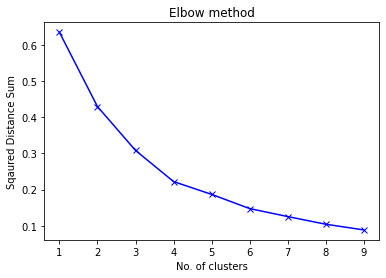

In [38]:
sum_of_sqrd=[]
downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans=kmeans.fit(downtown_grouped_clustering)
    sum_of_sqrd.append(kmeans.inertia_)
plt.plot(range(1,10),sum_of_sqrd,'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Sqaured Distance Sum')
plt.title('Elbow method')
plt.show()

In [30]:
kclusters = 4

downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 








array([1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1],
      dtype=int32)

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = downtown_data

# merge downtown_grouped with downtown_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.68190,-79.37829,2,Park,Shop & Service,Bike Trail,Tennis Court,Playground,Creperie,Dance Studio,Falafel Restaurant,Event Space,Costume Shop
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,1,Coffee Shop,Café,Restaurant,Pizza Place,Park,Bakery,Pub,Italian Restaurant,Chinese Restaurant,Market
2,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,1,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Café,Pub,Bubble Tea Shop,Dance Studio,Hotel
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,0,Coffee Shop,Breakfast Spot,Thai Restaurant,Event Space,Spa,Electronics Store,Food Truck,Restaurant,Bakery,Pub
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Theater,Bubble Tea Shop,Movie Theater,Italian Restaurant,Hotel


In [40]:

# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = downtown_data

# merge downtown_grouped with downtown_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_merged.head() # check the last columns!


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.68190,-79.37829,2,Park,Shop & Service,Bike Trail,Tennis Court,Playground,Creperie,Dance Studio,Falafel Restaurant,Event Space,Costume Shop
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,1,Coffee Shop,Café,Restaurant,Pizza Place,Park,Bakery,Pub,Italian Restaurant,Chinese Restaurant,Market
2,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133,1,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Café,Pub,Bubble Tea Shop,Dance Studio,Hotel
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,0,Coffee Shop,Breakfast Spot,Thai Restaurant,Event Space,Spa,Electronics Store,Food Truck,Restaurant,Bakery,Pub
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Theater,Bubble Tea Shop,Movie Theater,Italian Restaurant,Hotel


In [53]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighborhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# Various Clusters

## Cluster 1

In [34]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,0,Coffee Shop,Breakfast Spot,Thai Restaurant,Event Space,Spa,Electronics Store,Food Truck,Restaurant,Bakery,Pub
18,Downtown Toronto,0,Coffee Shop,Sandwich Place,Park,Theater,Bank,Falafel Restaurant,Gastropub,Italian Restaurant,Portuguese Restaurant,Café


## Cluster 2

In [35]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Pizza Place,Park,Bakery,Pub,Italian Restaurant,Chinese Restaurant,Market
2,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Café,Pub,Bubble Tea Shop,Dance Studio,Hotel
4,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Theater,Bubble Tea Shop,Movie Theater,Italian Restaurant,Hotel
5,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Hotel,Restaurant,Gastropub,Café,Cosmetics Shop,Clothing Store,Seafood Restaurant,Gym
6,Downtown Toronto,1,Coffee Shop,Bakery,Breakfast Spot,Seafood Restaurant,Cheese Shop,Farmers Market,Beer Bar,Cocktail Bar,Restaurant,Pub
7,Downtown Toronto,1,Coffee Shop,Clothing Store,Bookstore,Hotel,Cosmetics Shop,Restaurant,Bubble Tea Shop,Plaza,Sushi Restaurant,Café
8,Downtown Toronto,1,Coffee Shop,Hotel,Café,Japanese Restaurant,Restaurant,Gym,American Restaurant,Steakhouse,Salad Place,Asian Restaurant
9,Downtown Toronto,1,Coffee Shop,Hotel,Japanese Restaurant,Restaurant,Plaza,Boat or Ferry,Deli / Bodega,Aquarium,Park,IT Services
10,Downtown Toronto,1,Coffee Shop,Hotel,Restaurant,Café,Seafood Restaurant,American Restaurant,Salad Place,Japanese Restaurant,Italian Restaurant,Sporting Goods Shop
11,Downtown Toronto,1,Coffee Shop,Restaurant,Hotel,Café,Japanese Restaurant,Italian Restaurant,Gym,Beer Bar,Seafood Restaurant,American Restaurant


## Cluster 3

In [36]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,2,Park,Shop & Service,Bike Trail,Tennis Court,Playground,Creperie,Dance Studio,Falafel Restaurant,Event Space,Costume Shop


## Cluster 4

In [37]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 3, downtown_merged.columns[[1] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,3,Café,Grocery Store,Candy Store,Coffee Shop,Playground,Baby Store,Italian Restaurant,Athletics & Sports,Women's Store,Electronics Store
